In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from PIL import Image
from torch.utils.data import Dataset
import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
from torchmetrics import Accuracy, ConfusionMatrix
import psutil
from torch.utils.tensorboard import SummaryWriter

2024-04-17 22:30:29.215146: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 22:30:32.796685: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# writer = SummaryWriter('mylogs:/home/oa6121/Documents/Research/May Conf Work/results/logs')

In [2]:
def get_memory_usage():
    """ Gets the current memory usage of the process in MB """
    process = psutil.Process()
    return process.memory_info().rss / (1024 * 1024)

In [3]:
# Define the path to the train and test folders
train_folder = "./train_224/"
test_folder = "./test_224/"

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        
        # Get list of class names (subdirectories)
        self.class_names = sorted(os.listdir(root_dir))
        
        # Assign a label (class index) to each class name
        self.class_to_label = {class_name: i for i, class_name in enumerate(self.class_names)}
        
        # Load images and assign labels
        for class_name in self.class_names:
            class_dir = os.path.join(root_dir, class_name)
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                self.images.append(file_path)
                self.labels.append(self.class_to_label[class_name])
                
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert("RGB")  # Ensure image is converted to RGB
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Define transformations to be applied to the images
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create train and test datasets
# Load Data
batch_size = 64
train_dataset = CustomDataset(root_dir=train_folder, transform=train_transforms)
test_dataset = CustomDataset(root_dir=test_folder, transform=test_transforms)

In [4]:
print(train_dataset.labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


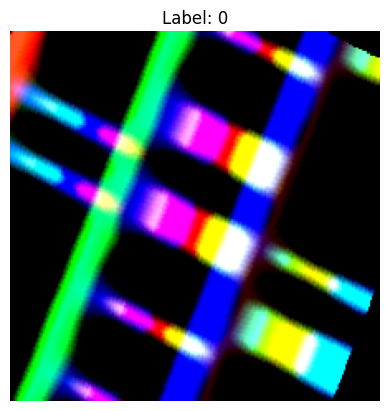

Training dataset size: 46628
Test dataset size: 18792


In [5]:
# Define a function to display a sample image
def show_sample(dataset, index):
    image, label = dataset[index]
    plt.imshow(image.permute(1, 2, 0))  # Convert from tensor to numpy array and rearrange dimensions
    plt.title(f"Label: {label}")
    print(label)
    plt.axis('off')
    plt.show()

# Display a sample image from the train dataset
show_sample(train_dataset, index=4)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


In [6]:
# Define data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


In [7]:
class CNN(nn.Module):
    def __init__(self, num_classes=15):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = x.view(-1, 512 * 14 * 14)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [8]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 2
num_classes=15
weight_decay=0.001
lr=5e-5

# Instantiate the model
model = CNN(num_classes=num_classes)

#     This two lines are added to compute the total and trainable parameters
print(f"Number of total parameters: ", sum(p.numel() for p in model.parameters()))
print(f"Number of trainable parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
# Define loss function and optimizer


model.classifier = nn.Sequential(nn.Linear(512, 100), nn.ReLU(), nn.Linear(100, 15))
model.to(device)


criterion = nn.CrossEntropyLoss()
# optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
# train_losses = []
# accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes)
# train_accuracy = []
# confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)
# Train the model

Number of total parameters:  104327823
Number of trainable parameters:  104327823


In [9]:
%%time
# Train Network
losses = []
epoches = []
batch = []
losses_n = []
before_memory = get_memory_usage()
for epoch in range(num_epochs):
    running_loss = 0.0
    running_loss_n = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        # (1pt) TODO: Get data to cuda if possible
        if torch.cuda.is_available():
            data = data.cuda()
            targets = targets.cuda()

        # (1pt) TODO: forward
        output = model(data)
        # loss = loss_fn(output, targets)
        loss = criterion(output, targets)
        # running_loss += loss.item() * data.size(0)        
#         running_loss_n += loss.item()
        losses.append(loss.item())
        epoches.append(epoch)
        batch.append(batch_idx)
       

        # (1pt) TODO: gradient descent or adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         accuracy = accuracy_metric(output, targets)
#         train_accuracy.append(accuracy.item().to(device))

        # Log GPU memory usage
#         if batch_idx % log_interval == 0:
            # Calculate GPU memory usage
        gpu_memory_usage = torch.cuda.max_memory_allocated() / 1024.0 / 1024.0  # in MB
    
#     losses.append(running_loss)
#     losses_n.append(running_loss_n)
#     epoches.append(epoch)
    print(f"Loss at epoch {epoch + 1} is {sum(losses)/len(losses):.5f}")
    print(f"gpu_memory_usage {epoch + 1} is {gpu_memory_usage:.5f}")
    
after_memory = get_memory_usage()
print(f"Training memory used: {after_memory - before_memory} MB")
# writer.flush()
# writer.close()

Loss at epoch 1 is 0.82007
gpu_memory_usage 1 is 4929.99463
Loss at epoch 2 is 0.56847
gpu_memory_usage 2 is 4929.99463
Training memory used: 423.3828125 MB
CPU times: user 39min 37s, sys: 42.9 s, total: 40min 20s
Wall time: 5min 2s


In [10]:
def check_accuracy_n(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    # with torch.no_grad():
    for x, y in loader:
        x = x.to(device=device)
        y = y.to(device=device)

    y_pred = model(x)
    acc = (torch.argmax(y_pred, 1) == y).float().mean()
    print("Accuracy: %.2f" % acc)


    # print(
    #     f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
    # )

In [15]:
print(f"Train Accuracy: {check_accuracy_n(train_loader, model)}%")
print(f"Validation Accuracy: {check_accuracy_n(val_loader, model)}%")

Accuracy: 0.92
Train Accuracy: None%
Accuracy: 0.82
Validation Accuracy: None%


In [12]:
import torch
from transformers import (AutoModelForCausalLM, 
                          AutoTokenizer, 
                          BitsAndBytesConfig, 
                          pipeline)
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np


def load_model(model_name, bnb_config):
    n_gpus = torch.cuda.device_count()
    max_memory = "10000MB"

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto", # dispatch efficiently the model on the available ressources
        max_memory = {i: max_memory for i in range(n_gpus)},
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name)
# , use_auth_token=True

    # Needed for LLaMA tokenizer
    tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer

def create_bnb_config():
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )

    return bnb_config

# model_name =  "google/gemma-2b-it" #"meta-llama/Llama-2-13b-chat-hf"
model_name = "google/recurrentgemma-2b-it"

bnb_config = create_bnb_config()

model, tokenizer = load_model(model_name, bnb_config)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of RecurrentGemmaForCausalLM were not initialized from the model checkpoint at google/recurrentgemma-2b-it and are newly initialized: ['model.normalizer']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:

def make_inference(text):    
    prompt = f"""
    As a Cyber Security Operations Specialist, your role encompasses incident analysis. 
    You have recently detected a {text} on the network. 
    Please provide the following details about the incident:
    The objective the attacker aimed to accomplish. 
    Your recommended solution to prevent, mitigate, and recover from this attack.
    """
    USER_CHAT_TEMPLATE = [
        { "role": "user", "content": f"{prompt}" },
    ]

    prompt = tokenizer.apply_chat_template(USER_CHAT_TEMPLATE, tokenize=False, add_generation_prompt=True)

    inputs = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt")
    output_ids = model.generate(
        input_ids=inputs.to(model.device), 
#         device=device,
        max_new_tokens=150
    )
#     rewritten_text = tokenizer.decode(outputs[0][len(encoding['input_ids'][0]):], skip_special_tokens=True)
    resp = tokenizer.decode(output_ids[0])[len(prompt):]
    # Split the string into lines using the newline character ('\n')
    lines = resp.split('\n')

    # Remove asterisks from each line
    cleaned_lines = [line.replace('*', '') for line in lines]

    # Join the cleaned lines back together with newline characters
    cleaned_string = '\n'.join(cleaned_lines)

    return cleaned_string



    

SyntaxError: incomplete input (42973666.py, line 35)

In [23]:
def parse_txt(resp):
    lines = resp.split('\n')

    # Remove asterisks from each line
    cleaned_lines = [line.replace('*', '') for line in lines]

    # Join the cleaned lines back together with newline characters
    cleaned_string = '\n'.join(cleaned_lines)

    return cleaned_string

In [20]:
# Load the single image
image_path = '/home/oa6121/Documents/Classwork/Spring 2024/Deep Learning/Project/main_work/data/1/183994.png'
image = Image.open(image_path)
print(image)
# Apply preprocessing to the image
input_image = test_transforms(image)
# input_image = input_image.unsqueeze(0)  # Add batch dimension
# input_image = input_image.to(device=device)

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7FE578D8EF50>


In [21]:
import torch.nn.functional as F

label =['DDOS attack-HOIC', 'FTP-BruteForce', 'Bot', 'SSH-Bruteforce', 'Infilteration', 'DoS attacks-GoldenEye', 'DDoS attacks-LOIC-HTTP', 'Brute Force -Web', 'Brute Force -XSS'
 'SQL Injection', 'DoS attacks-SlowHTTPTest', 'DoS attacks-Hulk', 'DoS attacks-Slowloris', 'DDOS attack-LOIC-UDP', 'Benign']
# Make predictions
with torch.no_grad():
    output = model(input_image)

# Convert the output probabilities to predicted class
probabilities = F.softmax(output, dim=1)
predicted_class = torch.argmax(probabilities, dim=1).item()

# Print the predicted class
print("Predicted class:", predicted_class)
print("Predicted attack:", label[predicted_class])

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.cuda.FloatTensor instead (while checking arguments for embedding)

In [33]:
make_inference(label[predicted_class])

'## Incident Details: DDoS-LOIC-HTTP Attack\n\n**Objective:** The attacker aimed to disrupt normal network operations by overwhelming the system with a flood of traffic, potentially causing denial-of-service (DoS) attacks.\n\n**Recommended Solutions:**\n\n**Prevention:**\n\n* **Deploy a DDoS mitigation solution:** This solution will analyze traffic patterns and identify and filter out malicious attacks.\n* **Implement rate limiting:** This will limit the amount of traffic that can enter the network from a single source.\n* **Monitor network traffic:** Regularly monitor network traffic for suspicious activity and investigate any unusual patterns.\n* **Educate users:** Train employees on how to identify and avoid phishing attacks and other social engineering techniques used in DDoS attacks.\n\n**'

In [24]:
str = '## Incident Details: DDoS-LOIC-HTTP Attack\n\n**Objective:** The attacker aimed to disrupt normal network operations by overwhelming the system with a flood of traffic, potentially causing denial-of-service (DoS) attacks.\n\n**Recommended Solutions:**\n\n**Prevention:**\n\n* **Deploy a DDoS mitigation solution:** This solution will analyze traffic patterns and identify and filter out malicious attacks.\n* **Implement rate limiting:** This will limit the amount of traffic that can enter the network from a single source.\n* **Monitor network traffic:** Regularly monitor network traffic for suspicious activity and investigate any unusual patterns.\n* **Educate users:** Train employees on how to identify and avoid phishing attacks and other social engineering techniques used in DDoS attacks.\n\n**'
parse_txt(str)

'## Incident Details: DDoS-LOIC-HTTP Attack\n\nObjective: The attacker aimed to disrupt normal network operations by overwhelming the system with a flood of traffic, potentially causing denial-of-service (DoS) attacks.\n\nRecommended Solutions:\n\nPrevention:\n\n Deploy a DDoS mitigation solution: This solution will analyze traffic patterns and identify and filter out malicious attacks.\n Implement rate limiting: This will limit the amount of traffic that can enter the network from a single source.\n Monitor network traffic: Regularly monitor network traffic for suspicious activity and investigate any unusual patterns.\n Educate users: Train employees on how to identify and avoid phishing attacks and other social engineering techniques used in DDoS attacks.\n\n'

In [ ]:
# Iterate through the data loader and make predictions
def make_prediction(loader, model):
    model.eval()

    # with torch.no_grad():
    for x, y in loader:
        x = x.to(device=device)
        y = y.to(device=device)
    # Make predictions using the loaded model
    with torch.no_grad():
        outputs = model(images)
        
    y_pred = model(x)
    acc = (torch.argmax(y_pred, 1) == y).float().mean()
    print("Accuracy: %.2f" % acc)

In [10]:
# Check accuracy on training & test to see how good our model
correct = []
sample = []
def check_accuracy(loader, model):
#     if loader.dataset.train:
#         print("Checking accuracy on training data")
#     else:
#         print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            correct.append((predictions == y).sum().item())
            sample.append(predictions.size(0))

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )

    # model.train()

print(f"Train Accuracy: {check_accuracy(train_loader, model)}%")
print(f"Validation Accuracy: {check_accuracy(val_loader, model)}%")

Got 44369 / 46628 with accuracy 95.16
Train Accuracy: None%
Got 15356 / 18792 with accuracy 81.72
Validation Accuracy: None%


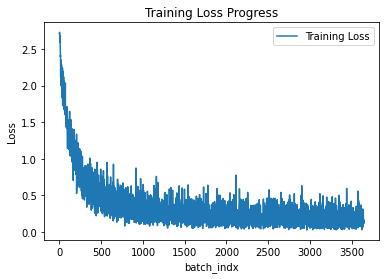

In [11]:
# Plot the training loss
plt.plot(losses, label='Training Loss')
plt.xlabel('batch_indx')
plt.ylabel('Loss')
plt.title('Training Loss Progress')
plt.legend()
plt.show()

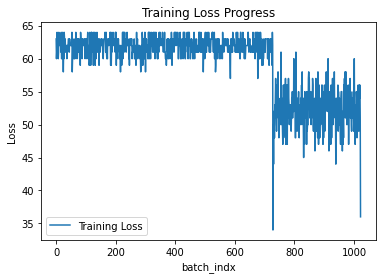

In [12]:
# # Plot the training loss
# correct = []
# sample = []
plt.plot(correct, label='Training Loss')
plt.xlabel('batch_indx')
plt.ylabel('Loss')
plt.title('Training Loss Progress')
plt.legend()
plt.show()

In [13]:
# Save the trained model
torch.save(model.state_dict(), './models/trained_model_5.pth')